<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-nnqf.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://minhaskamal.github.io/DownGit/#/home?url=https://github.com/pavelzw/GEFCom14-S-comparison/blob/main/gefcom14-s-deepar.ipynb&fileName=gefcom14-s-nnqf"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

# Download data

In [1]:
!echo "Downloading GEFCom14-S..."
!rm -R data > /dev/null
!wget -O gefcom14.zip https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
!unzip gefcom14 > /dev/null
!rm gefcom14.zip > /dev/null
!unzip GEFCom2014\ Data/GEFCom2014-S_V2.zip > /dev/null
!rm -R GEFCom2014\ Data > /dev/null
!mv Solar data > /dev/null
!echo "------------------------------"
!echo "Downloaded GEFCom14-S in data/"

--2021-06-26 14:59:45--  https://www.dropbox.com/s/pqenrr2mcvl0hk9/GEFCom2014.zip?dl=0
Resolving www.dropbox.com (www.dropbox.com)... 162.125.64.18, 2620:100:6021:18::a27d:4112
Connecting to www.dropbox.com (www.dropbox.com)|162.125.64.18|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: /s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip [following]
--2021-06-26 14:59:45--  https://www.dropbox.com/s/raw/pqenrr2mcvl0hk9/GEFCom2014.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc68303ac4f4e3b0631ccf8d49a5.dl.dropboxusercontent.com/cd/0/inline/BRJpbR9A52BnBRWLKd8nP7LdSwC9iyWu6IVx2dN5ghDMkhPI9E396xXiclbYoShWbA4RGTQ7niSBUzOf4IhruPlguVXCCa6coaXwlByH9lCKVkWLTA0xU-rbIs0_rgEs_wMXnjVjSBu-xpR3kw_unPED/file# [following]
--2021-06-26 14:59:46--  https://uc68303ac4f4e3b0631ccf8d49a5.dl.dropboxusercontent.com/cd/0/inline/BRJpbR9A52BnBRWLKd8nP7LdSwC9iyWu6IVx2dN5ghDMkhPI9E396xXiclbYoShWbA4RGTQ7niSB

# Select Task

In [2]:
task = 9

# Prepare data

In [3]:
import numpy as np
import pandas as pd

predictors = pd.read_csv(f'data/Task {task}/predictors{task}.csv', parse_dates=['TIMESTAMP'])\
    [['ZONEID', 'TIMESTAMP', 'VAR164', 'VAR169', 'VAR175', 'VAR178', 'VAR228']].set_index('TIMESTAMP')
train = pd.read_csv(f'data/Task {task+1}/train{task+1}.csv', parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')
benchmark = pd.read_csv(f"data/Task {task}/benchmark{'0' + str(task) if task < 10 else task}.csv",
                        parse_dates=['TIMESTAMP']).set_index('TIMESTAMP')

solar_plants = [train[train['ZONEID'] == i][['POWER']].rename({'POWER': f'ZONEID {i}'}, axis='columns')
                for i in [1,2,3]]
train_data = pd.concat(solar_plants, axis=1)

predictors['VAR164*169'] = predictors['VAR164'] * predictors['VAR169']

predictors_categories = [predictors[predictors['ZONEID'] == i][['VAR169', 'VAR175', 'VAR178', 'VAR228', 'VAR164']]
                             .rename({'VAR169': f'SSRD {i}',
                                      'VAR175': f'STRD {i}',
                                      'VAR178': f'TSR {i}', 
                                      'VAR228': f'TP {i}',
                                      'VAR164': f'TCC {i}'}, axis='columns')
                         for i in [1,2,3]]
predictor_data = pd.concat(predictors_categories, axis=1)

In [4]:
gefcom14_metadata = {
    'num_series': 3,
    'num_steps': len(predictor_data),
    'prediction_length': len(benchmark) // 3,
    'start': predictor_data.index[0]
}

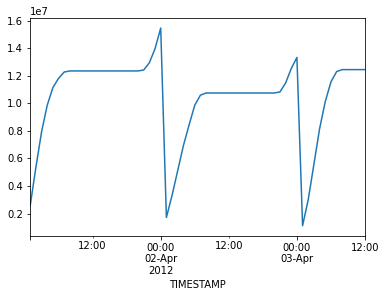

In [5]:
predictor_data['SSRD 1'][:60].plot()

In [6]:
# decumulate data
from itertools import product

for name, zoneid in product(['SSRD', 'STRD', 'TSR'], range(1, 4)):
    subtract = predictor_data[f'{name} {zoneid}'].shift(1)
    subtract.iloc[::24] = 0

    predictor_data[f'{name} {zoneid}'] -= subtract

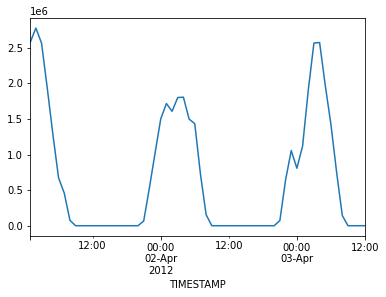

In [7]:
predictor_data['SSRD 1'].iloc[:60].plot()

In [8]:
for i in range(1, 4):
    predictor_data[f'SSRD {i}'] /= predictor_data[f'SSRD {i}'].max()
    predictor_data[f'STRD {i}'] /= predictor_data[f'STRD {i}'].max()
    predictor_data[f'TSR {i}'] /= predictor_data[f'TSR {i}'].max()
    predictor_data[f'TP {i}'] /= predictor_data[f'TP {i}'].max()

In [9]:
predictor_zones = []
train_data_zones = []

for zoneid in range(1, 4):
    predictor = predictor_data[[f'SSRD {zoneid}', f'STRD {zoneid}', f'TSR {zoneid}', f'TP {zoneid}', f'TCC {zoneid}']]
    predictor_zones.append(predictor)
    train_data_zone = train_data[[f'ZONEID {zoneid}']]
    train_data_zones.append(train_data_zone)

In [10]:
x_input_zones = []
y_output_zones = []

for predictor, train_data in zip(predictor_zones, train_data_zones):
    x_input_df = predictor[:-gefcom14_metadata['prediction_length']]
    x_input = np.array(x_input_df)
    x_input_zones.append(x_input)
    y_output = np.array(train_data[:-gefcom14_metadata['prediction_length']])
    y_output_zones.append(y_output)

# NNQF

In [11]:
import numpy as np
from sklearn.neighbors import NearestNeighbors as nn_fun

def nnqf_filter(x_input, 
                y_output, 
                num_neighbors = 10, 
                q_quantile = 0.5, 
                var_weighting = True, 
                minkowski_dist = 2):
    """
    Parameters
    ----------
    x_input : numpy array ;
    Input matrix of dimension (N,S), with N representing the number of
    samples and S the number of features

    y_output : numpy array ;
    Output vector of dimension (N,)

    num_neighbors : int, default = 10 ;
    Number of nearest neighbors that the filter is going to search for     

    q_quantile : float, default = 0.5 ;
    Must be a value between 0 and 1. 
    Probability of the quantile that is going to be calculated from the 
    nearest neighbors output values      

    var_weighting : bool, default = True ;
    Value defining if the columns of the input matrix are going to be multiplied 
    by the inverse of their variance

    minkowski_dist : int, default = 2 ;
    Parameter used to define the type of minkoswki distance used to calculate 
    the nearest neighbors

    Returns
    -------
    yq_output : numpy array ;
    New output vector containing the quantiles of the output values of the
    input's nearest neighbors

    """
    # --
    # Each column of the input matrix is multiplied by the inverse of its variance, 
    # in order to avoid a feature with a huge scale to overpower the others at the 
    # moment of calculating the distances

    if var_weighting:
        var_weights = np.var(x_input, axis=0)
        x_input = var_weights ** (-1) * x_input    

    # --
    # We calculate the nearest neighbor of each feature vector within the input matrix
    # and obtain their corresponding indices
    # The distance used is the minkowski distance with p = minkowski_dist

    x_neighbors = nn_fun(n_neighbors=num_neighbors, algorithm='auto', p=minkowski_dist).fit(x_input)
    dist, indx = x_neighbors.kneighbors(x_input)


    # --
    # We create a matrix containing the output values of nearest neighbors of
    # each input vector

    y_neighbors = y_output[indx[0,:]].T
    for i in range(1, np.size(x_input, 0)):
        values_to_add = y_output[indx[i,:]].T
        y_neighbors = np.vstack([y_neighbors, values_to_add])

    # --
    # We calculate the q_quantile of the nearest neighbors output values
    # and create with them a new output vector yq_output

    yq_output = np.quantile(y_neighbors, q=q_quantile, axis=1)
        
    return yq_output

In [12]:
from tqdm import tqdm

yq_output_zones = []

for x_input, y_output in tqdm(zip(x_input_zones, y_output_zones)):
    yq_output = nnqf_filter(x_input=x_input, y_output=y_output,
                            q_quantile=[p / 100 for p in range(1, 100)],
                            num_neighbors=100).T
    yq_output_df = pd.DataFrame(yq_output, index=x_input_df.index)\
        .rename(columns={p: str((p+1)/100) for p in range(99)})
    yq_output_zones.append(yq_output_df)

3it [00:32, 10.85s/it]


In [13]:
yq_output_zones[0].head()

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
TIMESTAMP,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2012-04-01 01:00:00,0.000127,0.070676,0.161032,0.197321,0.218144,0.219649,0.246029,0.260869,0.263796,0.265071,0.271297,0.281133,0.287391,0.291779,0.298093,0.305295,0.307858,0.317813,0.322896,0.326615,0.331929,0.335541,0.343671,0.359782,0.393109,0.409540,0.413748,0.418438,0.421092,0.422571,0.427392,0.430231,0.431156,0.444060,0.451285,0.457205,0.463471,0.467347,0.471053,0.481282,...,0.582577,0.585173,0.588222,0.591946,0.593123,0.594237,0.602583,0.615847,0.620615,0.629299,0.635513,0.641562,0.646031,0.648610,0.653773,0.662644,0.666592,0.667770,0.669187,0.669581,0.671231,0.676544,0.678569,0.685813,0.689944,0.695763,0.696126,0.696579,0.703541,0.743338,0.745006,0.745889,0.748695,0.752129,0.752415,0.754282,0.757897,0.762869,0.765105,0.799210
2012-04-01 02:00:00,0.126721,0.163046,0.180944,0.183013,0.197692,0.201595,0.230351,0.259628,0.271146,0.274359,0.296694,0.299536,0.317286,0.327709,0.332516,0.338256,0.359928,0.399069,0.410937,0.413923,0.416550,0.421265,0.426088,0.428300,0.428990,0.430810,0.445402,0.455238,0.457597,0.465359,0.468988,0.471521,0.474260,0.477306,0.486795,0.492431,0.496308,0.502458,0.509209,0.513244,...,0.603615,0.613373,0.628517,0.635555,0.644567,0.647785,0.654385,0.657156,0.658223,0.659666,0.661910,0.666980,0.672077,0.680904,0.683208,0.689167,0.701205,0.709572,0.718873,0.724777,0.736051,0.739143,0.743464,0.745383,0.747841,0.749670,0.751885,0.752519,0.754592,0.767052,0.778231,0.781225,0.785926,0.787113,0.788963,0.792814,0.812687,0.825374,0.842110,0.867338
2012-04-01 03:00:00,0.059335,0.074941,0.078365,0.086092,0.089455,0.098533,0.099401,0.100779,0.115306,0.142577,0.165303,0.175485,0.181613,0.193287,0.197952,0.201262,0.205147,0.213718,0.216331,0.229205,0.246197,0.255522,0.259830,0.263174,0.269263,0.273682,0.292491,0.305287,0.313381,0.316288,0.318883,0.326082,0.337049,0.346441,0.350772,0.359644,0.366428,0.367876,0.371624,0.376936,...,0.480141,0.483376,0.488415,0.493440,0.499821,0.503522,0.506132,0.510172,0.517141,0.524018,0.527718,0.535209,0.543831,0.556004,0.563301,0.578381,0.584964,0.587713,0.592155,0.593555,0.595436,0.598715,0.603781,0.609232,0.622418,0.638699,0.665318,0.668988,0.671421,0.685029,0.707423,0.713683,0.743151,0.744319,0.758596,0.765949,0.808995,0.826135,0.867688,0.902115
2012-04-01 04:00:00,0.025881,0.026840,0.027792,0.029790,0.031760,0.034450,0.037000,0.042487,0.044115,0.049308,0.053466,0.057859,0.059290,0.059478,0.072891,0.084303,0.086345,0.086410,0.089006,0.091103,0.095424,0.096824,0.097861,0.098141,0.098862,0.099340,0.100499,0.101313,0.101520,0.103603,0.104797,0.105067,0.109079,0.112591,0.114064,0.115203,0.116328,0.117128,0.117841,0.119756,...,0.187692,0.191388,0.199912,0.207939,0.208510,0.211747,0.219568,0.227649,0.237797,0.249872,0.251814,0.256569,0.261136,0.279349,0.302474,0.308830,0.313074,0.316899,0.328217,0.357249,0.368923,0.370838,0.379262,0.388067,0.398082,0.410792,0.427262,0.440522,0.458151,0.483987,0.491532,0.504894,0.579231,0.612263,0.622396,0.657026,0.659392,0.671538,0.740003,0.743474
2012-04-01 05:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000053,0.000222,0.001814,0.003256,0.004640,0.005686,0.006588,0.008110,0.008958,0.009767,0.013790,0.018562,0.020873,0.025410,0.029037,0.030918,0.033042,0.036046,0.037388,0.039551,0.042078,0.042924,0.043183,0.044872,...,0.094628,0.097124,0.099651,0.102993,0.104787,0.107654,0.115932,0.128476,0.138521,0.140849,0.145545,0.147591,0.152769,0.155671,0.158609,0.162196,0.173197

# Train the linear regression model (ANN6)

In [14]:
predictor_zones[0].head()

,SSRD 1,STRD 1,TSR 1,TP 1,TCC 1
TIMESTAMP,,,,,
2012-04-01 01:00:00,0.633853,0.749657,0.673847,0.000000,0.244601
2012-04-01 02:00:00,0.683136,0.775649,0.727011,0.000000,0.457138
2012-04-01 03:00:00,0.630869,0.769635,0.703986,0.028372,0.771429
2012-04-01 04:00:00,0.476707,0.773120,0.563346,0.052930,0.965866
2012-04-01 05:00:00,0.315368,0.830914,0.417683,0.070487,0.944669


In [15]:
for zoneid in range(1, 4):
    # remove timecode
    predictor = predictor_zones[zoneid-1].reset_index(drop=True).rename(columns={
        f'SSRD {zoneid}': 'SSRD',
        f'STRD {zoneid}': 'STRD',
        f'TSR {zoneid}': 'TSR', 
        f'TP {zoneid}': 'TP',
        f'TCC {zoneid}': 'TCC'})
    predictor_zones[zoneid-1] = predictor

predictor_zones[0]

,SSRD,STRD,TSR,TP,TCC
0,0.633853,0.749657,0.673847,0.000000,0.244601
1,0.683136,0.775649,0.727011,0.000000,0.457138
2,0.630869,0.769635,0.703986,0.028372,0.771429
3,0.476707,0.773120,0.563346,0.052930,0.965866
4,0.315368,0.830914,0.417683,0.070487,0.944669
...,...,...,...,...,...
15355,0.053123,0.687016,0.077673,0.001617,0.163549
15356,0.234686,0.720799,0.276505,0.001687,0.114380
15357,0.443417,0.705758,0.479557,0.001687,0.360260
15358,0.603365,0.740379,0.641488,0.001687,0.851685


## Prepare data for regression model

In [16]:
h = 24
h1 = 24

x_zones = []

for predictor in predictor_zones:
    x_pieces = []
    for i in range(h1):
        piece = predictor.drop(range(i)).reset_index().drop('index', axis=1)\
            .rename(columns={'SSRD': f't-{h1 - i - 1}: SSRD',
                             'STRD': f't-{h1 - i - 1}: STRD',
                             'TSR': f't-{h1 - i - 1}: TSR',
                             'TP': f't-{h1 - i - 1}: TP',
                             'TCC': f't-{h1 - i - 1}: TCC'})
        x_pieces.insert(0, piece)

    x = pd.concat(x_pieces, axis=1)
    x.index = x.index.map(lambda x: x + h1 - 1)
    x = x[:-h+1]
    x_zones.append(x)

x_zones[0]

,t-0: SSRD,t-0: STRD,t-0: TSR,t-0: TP,t-0: TCC,t-1: SSRD,t-1: STRD,t-1: TSR,t-1: TP,t-1: TCC,t-2: SSRD,t-2: STRD,t-2: TSR,t-2: TP,t-2: TCC,t-3: SSRD,t-3: STRD,t-3: TSR,t-3: TP,t-3: TCC,t-4: SSRD,t-4: STRD,t-4: TSR,t-4: TP,t-4: TCC,t-5: SSRD,t-5: STRD,t-5: TSR,t-5: TP,t-5: TCC,t-6: SSRD,t-6: STRD,t-6: TSR,t-6: TP,t-6: TCC,t-7: SSRD,t-7: STRD,t-7: TSR,t-7: TP,t-7: TCC,...,t-16: SSRD,t-16: STRD,t-16: TSR,t-16: TP,t-16: TCC,t-17: SSRD,t-17: STRD,t-17: TSR,t-17: TP,t-17: TCC,t-18: SSRD,t-18: STRD,t-18: TSR,t-18: TP,t-18: TCC,t-19: SSRD,t-19: STRD,t-19: TSR,t-19: TP,t-19: TCC,t-20: SSRD,t-20: STRD,t-20: TSR,t-20: TP,t-20: TCC,t-21: SSRD,t-21: STRD,t-21: TSR,t-21: TP,t-21: TCC,t-22: SSRD,t-22: STRD,t-22: TSR,t-22: TP,t-22: TCC,t-23: SSRD,t-23: STRD,t-23: TSR,t-23: TP,t-23: TCC
23,0.368656,0.854196,0.442339,0.143899,0.932465,0.250320,0.788924,0.314938,0.143687,0.953293,0.130317,0.765714,0.174183,0.143536,0.832794,0.016285,0.694786,0.030086,0.143435,0.623688,0.000000,0.730295,0.000000,0.143284,0.891571,0.000000,0.747231,0.000000,0.143102,0.893005,0.000000,0.743501,0.000000,0.142941,0.970123,0.000000,0.715054,0.000000,0.142830,0.937317,...,0.018859,0.774604,0.044175,0.137048,0.788338,0.112818,0.773141,0.171144,0.105155,0.753142,0.165400,0.812934,0.257348,0.083795,0.641353,0.315368,0.830914,0.417683,0.070487,0.944669,0.476707,0.773120,0.563346,0.052930,0.965866,0.630869,0.769635,0.703986,0.028372,0.771429,0.683136,0.775649,0.727011,0.000000,0.457138,0.633853,0.749657,0.673847,0.000000,0.244601
24,0.422394,0.818798,0.513562,0.004051,0.830276,0.368656,0.854196,0.442339,0.143899,0.932465,0.250320,0.788924,0.314938,0.143687,0.953293,0.130317,0.765714,0.174183,0.143536,0.832794,0.016285,0.694786,0.030086,0.143435,0.623688,0.000000,0.730295,0.000000,0.143284,0.891571,0.000000,0.747231,0.000000,0.143102,0.893005,0.000000,0.743501,0.000000,0.142941,0.970123,...,0.000000,0.758146,0.000000,0.142295,0.502275,0.018859,0.774604,0.044175,0.137048,0.788338,0.112818,0.773141,0.171144,0.105155,0.753142,0.165400,0.812934,0.257348,0.083795,0.641353,0.315368,0.830914,0.417683,0.070487,0.944669,0.476707,0.773120,0.563346,0.052930,0.965866,0.630869,0.769635,0.703986,0.028372,0.771429,0.683136,0.775649,0.727011,0.000000,0.457138
25,0.395441,0.839785,0.504277,0.005573,0.685303,0.422394,0.818798,0.513562,0.004051,0.830276,0.368656,0.854196,0.442339,0.143899,0.932465,0.250320,0.788924,0.314938,0.143687,0.953293,0.130317,0.765714,0.174183,0.143536,0.832794,0.016285,0.694786,0.030086,0.143435,0.623688,0.000000,0.730295,0.000000,0.143284,0.891571,0.000000,0.747231,0.000000,0.143102,0.893005,...,0.000000,0.749834,0.000000,0.142719,0.501918,0.000000,0.758146,0.000000,0.142295,0.502275,0.018859,0.774604,0.044175,0.137048,0.788338,0.112818,0.773141,0.171144,0.105155,0.753142,0.165400,0.812934,0.257348,0.083795,0.641353,0.315368,0.830914,0.417683,0.070487,0.944669,0.476707,0.773120,0.563346,0.052930,0.965866,0.630869,0.769635,0.703986,0.028372,0.771429
26,0.443019,0.860700,0.536485,0.006023,0.768799,0.395441,0.839785,0.504277,0.005573,0.685303,0.422394,0.818798,0.513562,0.004051,0.830276,0.368656,0.854196,0.442339,0.143899,0.932465,0.250320,0.788924,0.314938,0.143687,0.953293,0.130317,0.765714,0.174183,0.143536,0.832794,0.016285,0.694786,0.030086,0.143435,0.623688,0.000000,0.730295,0.000000,0.143284,0.891571,...,0.000000,0.710517,-0.000090,0.142819,0.156774,0.000000,0.749834,0.000000,0.142719,0.501918,0.000000,0.758146,0.000000,0.142295,0.502275,0.018859,0.774604,0.044175,0.137048,0.788338,0.112818,0.773141,0.171144,0.105155,0.753142,0.165400,0.812934,0.257348,0.083795,0.641353,0.315368,0.830914,0.417683,0.070487,0.944669,0.476707,0.773120,0.563346,0.052930,0.965866
27,0.444153,0.840864,0.529245,0.006281,0.538910,0.443019,0.860700,0.536485,0.006023,0.768799,0.395441,0.839785,0.504277,0.005573,0.685303,0.422394,0.818798,0.513562,0.004051,0.830276,0.368656,0.854196,0.442339,0.143899,0.932465,0.250320,0.788924,0.314938,0.143687,0.953293,0.130317,0.765714,0.174183,0.143536,0

## Feature selection

In [17]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression

x_new_zones = []

for x, yq_output_df in zip(x_zones, yq_output_zones):
    x_select = x[:-gefcom14_metadata['prediction_length'] + 23]
    y_select = yq_output_df[str(0.5)]

    print(x_select.shape)
    print(y_select.shape)

    support = SelectKBest(f_regression, k=50).fit(x_select, y_select).get_support(indices=True)
    print(support)

    x_new = x.loc[:, x.columns[support]]
    x_new_zones.append(x_new)

(14616, 120)
(14616,)
[  0   1   2   5   7  10  12  15  17  30  32  35  37  40  41  42  45  46
  47  50  51  52  55  56  57  60  61  62  65  67  70  72  75  77  79  80
  82  84  95  97 100 102 105 107 110 112 113 115 117 118]
(14616, 120)
(14616,)
[  0   1   2   5   6   7  10  12  15  17  30  32  35  37  40  42  45  47
  50  52  55  57  60  62  65  67  70  72  75  77  79  80  82  84  89  95
  97  98 100 102 103 105 107 108 110 112 113 115 117 118]
(14616, 120)
(14616,)
[  0   2   5   7  10  12  15  17  30  32  35  37  40  42  45  47  50  52
  55  57  60  62  65  67  70  72  75  77  80  82  84  89  93  95  97  98
 100 102 103 105 107 108 110 112 113 114 115 117 118 119]


# Training

In [18]:
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor

from tqdm import tqdm

ensemble_size = 7

prediction_zones = []

for x_new, yq_output_df in zip(x_new_zones, yq_output_zones):
    prediction = pd.DataFrame()

    for p in tqdm(range(1, 100)):
        y_train = yq_output_df.reset_index().drop('TIMESTAMP', axis=1).drop(range(h1-1))[str(p/100)]
        x_train = x_new[:-gefcom14_metadata['prediction_length']]
        x_predict = x_new[-gefcom14_metadata['prediction_length']:]

        model = BaggingRegressor(base_estimator=MLPRegressor(hidden_layer_sizes=(20,10,)),
                                 n_estimators=ensemble_size)

        trained = model.fit(x_train, y_train)
        prediction.insert(p-1, str(p/100), trained.predict(x_predict))
    prediction_zones.append(prediction)

100%|██████████| 99/99 [08:48<00:00,  5.34s/it]


In [19]:
prediction_zones[0]

,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,0.4,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,0.336537,0.409308,0.442824,0.459788,0.463711,0.486445,0.546899,0.526711,0.562425,0.562735,0.561235,0.593308,0.612106,0.617895,0.637523,0.622433,0.637735,0.643943,0.651731,0.660978,0.666964,0.675596,0.680080,0.700038,0.698041,0.706358,0.698086,0.713810,0.714298,0.758295,0.725416,0.731748,0.719505,0.749697,0.768768,0.759045,0.770171,0.771809,0.775309,0.754214,...,0.828248,0.844528,0.830531,0.829064,0.832983,0.821350,0.852380,0.827726,0.838315,0.835770,0.839580,0.849478,0.850060,0.833023,0.867777,0.866366,0.876110,0.858020,0.880017,0.889538,0.846118,0.851261,0.858677,0.858679,0.872963,0.864754,0.873201,0.873452,0.864431,0.867982,0.871176,0.890956,0.853380,0.859585,0.861942,0.873809,0.863314,0.881749,0.889188,0.890301
1,0.368221,0.409719,0.437953,0.457709,0.471113,0.484084,0.500736,0.528399,0.540519,0.563249,0.568498,0.574134,0.572888,0.594063,0.589983,0.602891,0.604262,0.624676,0.608801,0.639099,0.647339,0.651895,0.644929,0.657525,0.652444,0.669582,0.689963,0.682785,0.694797,0.696892,0.686533,0.713313,0.676730,0.700032,0.722844,0.715088,0.725441,0.738961,0.717345,0.691620,...,0.806184,0.793529,0.783215,0.778912,0.781554,0.779971,0.798087,0.788292,0.805404,0.794194,0.806174,0.817344,0.802125,0.783748,0.818255,0.822582,0.820066,0.811219,0.800905,0.842532,0.825723,0.814334,0.813134,0.826005,0.826267,0.814829,0.830115,0.836552,0.830856,0.841516,0.816903,0.828969,0.824993,0.825803,0.825219,0.845683,0.835038,0.845191,0.858677,0.856441
2,0.352008,0.415974,0.446498,0.463855,0.465576,0.488900,0.499154,0.523532,0.520975,0.536477,0.540520,0.562968,0.561030,0.550125,0.572498,0.591625,0.598074,0.595447,0.612554,0.621078,0.608804,0.634860,0.628908,0.636332,0.656985,0.644426,0.648203,0.657726,0.691173,0.656743,0.689723,0.697197,0.686283,0.684024,0.700874,0.689801,0.706764,0.707003,0.711396,0.690275,...,0.785548,0.768091,0.779400,0.787540,0.777288,0.771924,0.780003,0.774880,0.800938,0.794607,0.813666,0.791894,0.803705,0.798090,0.803541,0.806450,0.818778,0.823508,0.803195,0.819827,0.831624,0.816825,0.825318,0.830528,0.825917,0.819611,0.838133,0.824727,0.841155,0.840093,0.825784,0.834446,0.848919,0.837939,0.845519,0.839726,0.845926,0.842237,0.869539,0.862862
3,0.293158,0.347436,0.369765,0.394399,0.393882,0.410058,0.452255,0.449769,0.462318,0.468629,0.479521,0.470358,0.487089,0.495908,0.509666,0.515066,0.525207,0.535197,0.519999,0.553698,0.543950,0.551510,0.563995,0.566401,0.577417,0.578960,0.581465,0.594838,0.625075,0.606232,0.604279,0.632648,0.627121,0.615955,0.641407,0.631522,0.658832,0.635246,0.668566,0.665420,...,0.735710,0.727317,0.743986,0.732975,0.738762,0.737704,0.742636,0.746470,0.744211,0.735521,0.760129,0.760862,0.759492,0.754481,0.757459,0.772739,0.761717,0.759446,0.766247,0.792389,0.797616,0.791503,0.796735,0.790584,0.796341,0.794880,0.806953,0.809419,0.796675,0.812084,0.807614,0.809116,0.816934,0.813736,0.824112,0.845116,0.839091,0.853413,0.842661,0.854837
4,0.223305,0.268083,0.288128,0.310675,0.312317,0.330702,0.355309,0.363953,0.376718,0.374743,0.374307,0.391665,0.414282,0.423637,0.426949,0.435228,0.438879,0.460863,0.464941,0.473866,0.470874,0.473030,0.490520,0.521311,0.520656,0.533167,0.532930,0.534095,0.550929,0.536794,0.543845,0.582163,0.557683,0.566071,0.567569,0.579834,0.590460,0.595769,0.606867,0.611524,...,0.702971,0.689447,0.704405,0.691853,0.704564,0.704401,0.709598,0.727752,0.718006,0.722391,0.739617,0.742376,0.726207,0.736117,0.749008,0.752260,0.740630,0.740880,0.750705,0.767302,0.756166,0.768619,0.750418,0.772163,0.754492,0.777532,0.775586,0.797996,0.771733,0.793440,0.796132,0.800552,0.790144,0.811603,0.818449,0.827108,0.818018,

# Postprocessing: Remove quantile crossing

In [20]:
predictions_no_quantile_crossing_zones = []

sorting = True

for i, prediction in enumerate(prediction_zones):
    if sorting:
        # eliminate quantile crossing by sorting
        prediction = np.maximum(prediction, 0)
        prediction.values.sort()
    else:
        # eliminate quantile crossing by taking the maximum
        prediction['0.01'] = np.maximum(prediction['0.01'], 0)
        for p in range(2, 100):
            prediction[str(p/100)] = np.maximum(prediction[str((p-1)/100)], prediction[str(p/100)])

    zoneid = i+1
    prediction.insert(0, 'ZONEID', zoneid)
    predictions_no_quantile_crossing_zones.append(prediction)

In [21]:
!mkdir -p results

In [22]:
prediction = pd.concat(predictions_no_quantile_crossing_zones)
prediction.to_csv(f'results/prediction_nnqf_task{task}.csv')
prediction

,ZONEID,0.01,0.02,0.03,0.04,0.05,0.06,0.07,0.08,0.09,0.1,0.11,0.12,0.13,0.14,0.15,0.16,0.17,0.18,0.19,0.2,0.21,0.22,0.23,0.24,0.25,0.26,0.27,0.28,0.29,0.3,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39,...,0.6,0.61,0.62,0.63,0.64,0.65,0.66,0.67,0.68,0.69,0.7,0.71,0.72,0.73,0.74,0.75,0.76,0.77,0.78,0.79,0.8,0.81,0.82,0.83,0.84,0.85,0.86,0.87,0.88,0.89,0.9,0.91,0.92,0.93,0.94,0.95,0.96,0.97,0.98,0.99
0,1,0.336537,0.409308,0.442824,0.459788,0.463711,0.486445,0.526711,0.546899,0.561235,0.562425,0.562735,0.593308,0.612106,0.617895,0.622433,0.637523,0.637735,0.643943,0.651731,0.660978,0.666964,0.675596,0.680080,0.698041,0.698086,0.700038,0.706358,0.713810,0.714298,0.719505,0.725416,0.731748,0.749697,0.754214,0.758295,0.759045,0.768768,0.770171,0.771809,...,0.829064,0.829620,0.830531,0.832983,0.833023,0.835770,0.838315,0.839580,0.844528,0.846118,0.849478,0.850060,0.851261,0.852119,0.852380,0.853380,0.856417,0.858020,0.858677,0.858679,0.859585,0.861942,0.863314,0.864431,0.864754,0.866366,0.867777,0.867982,0.871176,0.872963,0.873201,0.873452,0.873809,0.876110,0.880017,0.881749,0.889188,0.889538,0.890301,0.890956
1,1,0.368221,0.409719,0.437953,0.457709,0.471113,0.484084,0.500736,0.528399,0.540519,0.563249,0.568498,0.572888,0.574134,0.589983,0.594063,0.602891,0.604262,0.608801,0.624676,0.639099,0.644929,0.647339,0.651895,0.652444,0.657525,0.669582,0.676730,0.682785,0.686533,0.689963,0.691620,0.694797,0.696892,0.700032,0.713313,0.715088,0.717345,0.722844,0.725441,...,0.781554,0.783215,0.783748,0.784344,0.788292,0.789657,0.793529,0.794194,0.798087,0.800905,0.802125,0.805404,0.806174,0.806184,0.811219,0.813134,0.814334,0.814829,0.816903,0.817344,0.818255,0.820066,0.822582,0.824993,0.825219,0.825723,0.825803,0.826005,0.826267,0.828969,0.830115,0.830856,0.835038,0.836552,0.841516,0.842532,0.845191,0.845683,0.856441,0.858677
2,1,0.352008,0.415974,0.446498,0.463855,0.465576,0.488900,0.499154,0.520975,0.523532,0.536477,0.540520,0.550125,0.561030,0.562968,0.572498,0.591625,0.595447,0.598074,0.608804,0.612554,0.621078,0.628908,0.634860,0.636332,0.644426,0.648203,0.656743,0.656985,0.657726,0.684024,0.686283,0.689723,0.689801,0.690275,0.691173,0.697197,0.700874,0.706764,0.707003,...,0.774880,0.776905,0.777288,0.779400,0.779461,0.780003,0.785548,0.787540,0.791894,0.794607,0.798090,0.800938,0.803195,0.803541,0.803705,0.806450,0.813666,0.816825,0.818778,0.819611,0.819827,0.823508,0.824727,0.825318,0.825784,0.825917,0.830528,0.831624,0.834446,0.837939,0.838133,0.839726,0.840093,0.841155,0.842237,0.845519,0.845926,0.848919,0.862862,0.869539
3,1,0.293158,0.347436,0.369765,0.393882,0.394399,0.410058,0.449769,0.452255,0.462318,0.468629,0.470358,0.479521,0.487089,0.495908,0.509666,0.515066,0.519999,0.525207,0.535197,0.543950,0.551510,0.553698,0.563995,0.566401,0.577417,0.578960,0.581465,0.594838,0.604279,0.606232,0.615955,0.625075,0.627121,0.631522,0.632648,0.635246,0.641407,0.658549,0.658832,...,0.727317,0.732975,0.735521,0.735710,0.737704,0.738762,0.742636,0.743986,0.744211,0.746470,0.754481,0.757459,0.759446,0.759492,0.760129,0.760862,0.761717,0.766247,0.772739,0.790584,0.791503,0.792389,0.794880,0.796341,0.796675,0.796735,0.797616,0.806953,0.807614,0.809116,0.809419,0.812084,0.813736,0.816934,0.824112,0.839091,0.842661,0.845116,0.853413,0.854837
4,1,0.223305,0.268083,0.288128,0.310675,0.312317,0.330702,0.355309,0.363953,0.374307,0.374743,0.376718,0.391665,0.414282,0.423637,0.426949,0.435228,0.438879,0.460863,0.464941,0.470874,0.473030,0.473866,0.490520,0.520656,0.521311,0.532930,0.533167,0.534095,0.536794,0.543845,0.550929,0.557683,0.566071,0.567569,0.579834,0.582163,0.590460,0.595769,0.606867,...,0.689447,0.691853,0.702971,0.704401,0.704405,0.704564,0.709598,0.718006,0.722391,0.726207,0.727752,0.736117,0.739617,0.740630,0.740880,0.742376,0.749008,0.750418,0.750705,0.752260,0.754492,0.756166,0.767302,0.768619,0.771733,0.772163,0.775586,0.777532,0.790144,0.793440,0.796132,0.797996,0.800552,0.811603,0.818018,0.818449,0.827108,0.830396,0.838188,0.845717
...,.

# Plotting the quantile prediction for the first entries

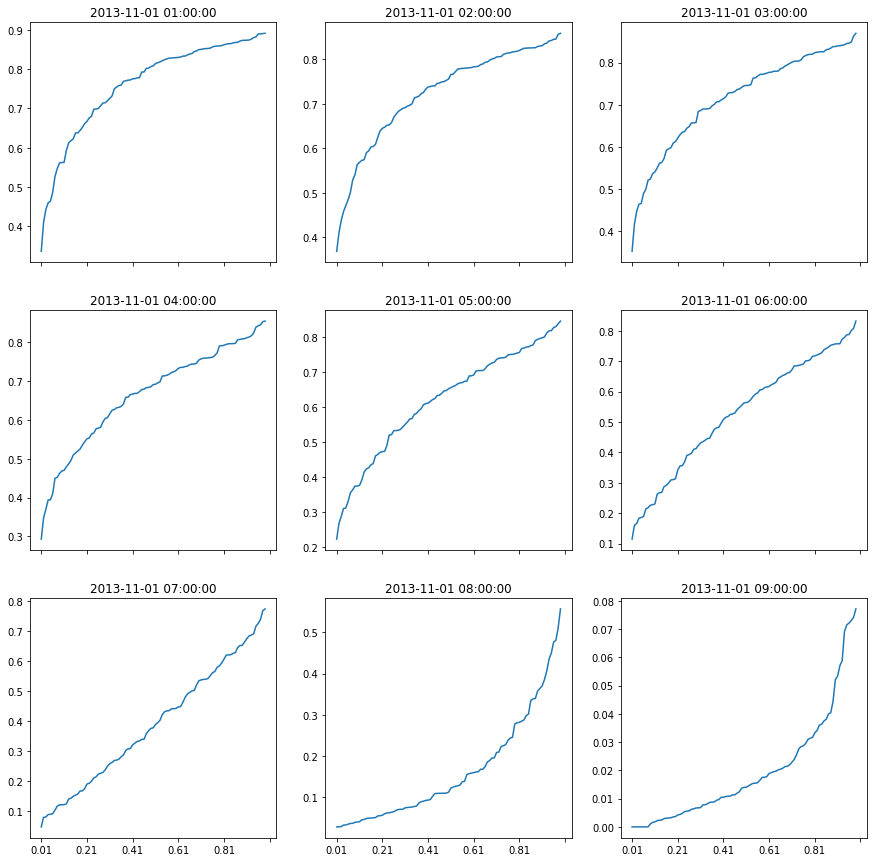

In [23]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(3, 3, sharex=True, figsize=(15, 15))

for i in range(9):
    prediction.iloc[i].tail(99).plot(ax=ax[i // 3, i % 3],
                                     title=str(yq_output_df[-24*30:].index[i]))

# Evaluate Loss

The loss function is the pinnball loss:
$$ L(q_a, y) = \begin{cases}
    (1-\frac{a}{100})(q_a - y), &\text{if } y < q_a \\
    \frac{a}{100}(y-q_a), &\text{if } y \geq q_a.
\end{cases} $$

The score is then averaged over all target quantiles for all time periods over the forecast horizon and for all zones.

In [24]:
def pinnball_loss(actual, prediction):
    actual = actual[...,None]

    percentiles = np.empty((actual.shape[0], 99))
    for i in range(1, 100):
        percentiles[:, i-1] = i
    loss = np.where(actual < prediction,
                    (1 - percentiles / 100) * (prediction - actual),
                    percentiles / 100 * (actual - prediction))
    return loss

In [25]:
test_ts1 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts2 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)
test_ts3 = np.squeeze(train_data_zones[0][-gefcom14_metadata['prediction_length']:].values)

prediction1 = prediction[prediction['ZONEID'] == 1].drop(columns='ZONEID')
prediction2 = prediction[prediction['ZONEID'] == 2].drop(columns='ZONEID')
prediction3 = prediction[prediction['ZONEID'] == 3].drop(columns='ZONEID')

loss1 = np.mean(pinnball_loss(test_ts1, prediction1))
loss2 = np.mean(pinnball_loss(test_ts2, prediction2))
loss3 = np.mean(pinnball_loss(test_ts3, prediction3))

loss = (loss1 + loss2 + loss3) / 3

print(f"Loss of task {task} with NNQF: {round(loss, 5)}")

Loss of task 9 with NNQF: 0.02427
